SETTING UP THE ENVIRONMENT

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

COLLECTING THE PATH INSIDE "NORMAL" AND "PNEUMONIA" FORLDERS OF THE ABOVE PATH

In [15]:
train_path = Path("/Users/radhikasingh/Desktop/Data Science/practice/chest_xray/train")
test_path = Path("/Users/radhikasingh/Desktop/Data Science/practice/chest_xray/test")
val_path = Path("/Users/radhikasingh/Desktop/Data Science/practice/chest_xray/val")

GET PATHS USING GLOB

In [50]:
train_image_paths = train_path.glob("*/*")
val_image_paths = val_path.glob("*/*")
test_image_paths = test_path.glob("*/*")

CONVERTING GENERATOR OBJECT TO IMAGE PATHS

In [51]:
train_image_paths = list(map(lambda x : str(x), train_image_paths))
val_image_paths = list(map(lambda x : str(x), val_image_paths))
test_image_paths = list(map(lambda x : str(x), test_image_paths))

GETTING IMAGE LABLES FROM PATH

In [52]:
LABELS = {"NORMAL":0, "PNEUMONIA": 1}
INV_LABELS = {0: "NORMAL", 1:"PNEUMONIA"}

def get_labels(path:str):
    return LABELS[path.split('/')[-2]]

train_labels = list(map(lambda x : get_labels(x), train_image_paths))
val_labels = list(map(lambda x : get_labels(x), val_image_paths))
test_labels = list(map(lambda x : get_labels(x), test_image_paths))


VECTORIZING THE IMAGE USING TESORFLOW

In [19]:
BATCH_SIZE = 32

def load_and_transform(image, label, train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [224,224], method = 'nearest')
    if train:
        image = tf.image.random_flip_left_right(image)
    return image, label

CREATING THE TENSORFLOW DATASET

In [41]:
def get_dataset(image_paths, labels, train = True):
    image_paths = tf.convert_to_tensor(image_paths)
    label_paths = tf.convert_to_tensor(labels)
    
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(label_paths)
    
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)
    
    dataset = dataset.map(lambda image, label : load_and_transform(image, label, 
                                                                   train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset
    
    

BUILDING RESNET50 MODEL

In [25]:
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
         input_shape = (224,224,3),
         include_top = False
          
)
model = tf.keras.Sequential([
       backbone,
       tf.keras.layers.GlobalAveragePooling2D(),
       tf.keras.layers.Dense(1, activation = 'sigmoid')
       
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


COMPILING THE MODEL

In [28]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall')]
    
   )

DEFINING OUR CALLBACKS

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose = 1, save_best_only = True,
                                               save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

TRAINING OUR MODEL

In [44]:
train_dataset = get_dataset(train_image_paths, train_labels)
val_dataset = get_dataset(val_image_paths, val_labels, train = False)

history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_image_paths)//BATCH_SIZE,
    epochs = 8,
    callbacks=[checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(val_image_paths)//BATCH_SIZE
    
)

Epoch 1/8
163/163 [==============================] - 2477s 15s/step - loss: 0.1665 - accuracy: 0.9331 - precision: 0.9591 - recall: 0.9580
Epoch 2/8
163/163 [==============================] - 2332s 14s/step - loss: 0.1280 - accuracy: 0.9534 - precision: 0.9668 - recall: 0.9706
Epoch 3/8
163/163 [==============================] - 2410s 15s/step - loss: 0.1130 - accuracy: 0.9582 - precision: 0.9719 - recall: 0.9724
Epoch 4/8
163/163 [==============================] - 2414s 15s/step - loss: 0.0851 - accuracy: 0.9689 - precision: 0.9778 - recall: 0.9799
Epoch 5/8
163/163 [==============================] - 2150s 13s/step - loss: 0.0761 - accuracy: 0.9724 - precision: 0.9821 - recall: 0.9811
Epoch 6/8
163/163 [==============================] - 2145s 13s/step - loss: 0.0740 - accuracy: 0.9730 - precision: 0.9811 - recall: 0.9824
Epoch 7/8
163/163 [==============================] - 2148s 13s/step - loss: 0.0645 - accuracy: 0.9776 - precision: 0.9847 - recall: 0.9850
Epoch 8/8
163/163 [========

VISUALISING THE TRAINING PROCESS PER EPOCH

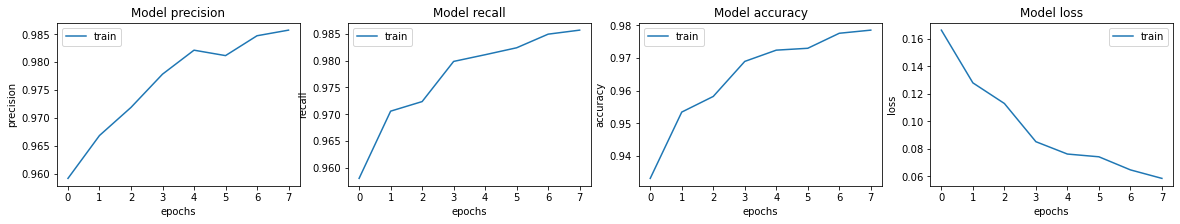

In [48]:
fig,ax = plt.subplots(1,4, figsize = (20,3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
    
    

In [49]:
model.save("model.h5")

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


TESTING OUR MODEL ON OUR TEST DATASET

In [56]:
test_dataset = (
      tf.data.Dataset
     .from_tensor_slices((test_image_paths, test_labels))
     .map(load_and_transform)
     .batch(BATCH_SIZE)
)

In [57]:
loss, acc, prec, rec = model.evaluate(test_dataset)

20/20 [==============================] - 57s 3s/step - loss: 3.6295 - accuracy: 0.6330 - precision: 0.6300 - recall: 1.0000


In [60]:
print(f"Loss: {loss}")
print(f"Acc:  {acc}")
print(f"Prec: {prec}")
print(f"Rec:  {rec}")

Loss: 3.6295323371887207
Acc:  0.6330128312110901
Prec: 0.6300484538078308
Rec:  1.0
